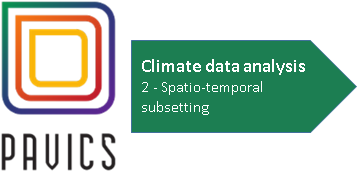pavics_climindices_2.png
<a id='top'></a>

In this second tutorial we will demonstate PAVICS subsetting tools, again accessing Ouranos' cb-oura-1.0 ensemble.  PAVICS subsetting relies on the `clisops` library enabling data extraction by:
* [Point location(s)](#point) 
* [Bounding box](#bbox) 
* [Polygon](#poly)
* [Time range](#time)

Advanced topics:
* [Extracting data using a `geopandas.GeoDataFrame`](#adv_gdf)
* [Creating a mask](#adv_mask)
* [Subsetting curvilinear Grids](#adv_curvil)

This tutorial uses [clisops](https://clisops.readthedocs.io/en/latest/notebooks/core_subset.html) for subsetting operations, and [geopandas](https://geopandas.org/) to manipulate region geometries.  

We re-use part of the data-access tutorial to select a dataset from cb-oura-1.0 datasets from the PAVICS THREDDS server.
___

*NOTE : To run this series of tutorials in the PAVICS jupyterhub, notebooks should be copied into your 'writable-workspace' directory*

In [ ]:
import xarray as xr
from siphon.catalog import TDSCatalog
from IPython.display import display  # Fancy representation of xarray objects
import warnings
warnings.simplefilter('ignore')
url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/simulations/bias_adjusted/cmip5/ouranos/cb-oura-1.0/catalog.xml"

# Create Catalog
cat = TDSCatalog(url)

# DAP link for this demo
ds_url = cat.datasets[0].access_urls["OPENDAP"]

# xarray.Dataset
ds = xr.open_dataset(ds_url, chunks=dict(time=256*2,lon=32,lat=32))
display(ds)
ds.tasmin.isel(time=0).plot(figsize=(10,4))

<a id='point'></a>
___
## Subsetting point location(s)

 The `subset_gridpoint` function returns the grid-cell whose center lies closest to the coordinates (latitude, longitude) given. When multiple coordinates are given, the various grid points are ordered along a new  `site` dimension.
 
 Use cases:
 
 - Compare gridded model output to observations at different weather station locations
 - Extract climate time series for cities or other sites of interest

*[return to top of page](#top)*

In [ ]:
from clisops.core import subset

lon=[-75.4, -85, -65.5]  # Longitude
lat=[46.67, 41, 55.3]  # Latitude

ds_gridpoint = subset.subset_gridpoint(ds, lon=lon, lat=lat)
display(ds_gridpoint)

# Plot first year of tasmax data
ds_gridpoint.tasmax.isel(time=slice(0,365)).plot.line(x='time')

The distance to the closest grid point can sometimes be so large that's it's not meaningful anymore. To avoid such cases, a maximum distance can be set using the `tolerance` argument. Also, the actual distance can also be added as a coordinate for manual inspection.

In [ ]:
subset.subset_gridpoint(ds, lon=lon, lat=lat, add_distance=True).distance

<a id='bbox'></a>
___
## Subsetting using a boundary box

The  `subset_bbox` function extracts data within latitude and longitude bounds (min, max). 

Use cases

- Extract a rectangular region around a site or region of interest
- Extract tropical, subtropical or polar latitudes

*[return to top of page](#top)*

In [ ]:
# Specify the longitude and latitude boundaries
lon_bnds = [-80.5, -60.2]
lat_bnds = [44, 55]

ds1 = subset.subset_bbox(ds, lon_bnds=lon_bnds, lat_bnds=lat_bnds)
display(ds1)

#Plot a map of first timestep
ds1.tasmax.isel(time=0).plot()

<a id='poly'></a>
___
## Subsetting using a polygon

The `subset_shape` function can extract data within an arbitrary shape defined by one or multiple polygons. It crops the original grid to the polygon then masks everything outside it. 

Use cases:

- Analyze climate variables within a country, state or watershed
- Study climate patterns over the Arctic ocean

The example below demonstate subsetting using a geojson layer for southern Quebec administative regions.

*[return to top of page](#top)*

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Explore the polygon layer
regions = gpd.GeoDataFrame.from_file('tutorial_data/test_regions.geojson')

# Display the first few columns
display(regions.head())

# Plot the layer to see what it looks like
display(regions.plot(figsize=(10,4)))


In [ ]:
# Subset over all regions 
ds_poly = subset.subset_shape(ds, shape='tutorial_data/test_regions.geojson') #use path to layer

ds_poly.tasmin.isel(time=0).plot(figsize=(10,4))

<a id='time'></a>
___
## Subsetting time

The `subset_time` fonction is used to extract a time span. It uses `start_date` and/or `end_date` arguments, which can be given as year, year-month or year-month-day strings. If the start or end date is not given, it defaults to the start or end date of the dataset respectively.

Use cases

- Align datasets to a common starting date
- Compute a climatology over 30-years

*[return to top of page](#top)*


In [ ]:
# Align data to a starting year
ds_sub = subset.subset_time(ds, start_date='1981')
print(f"Subset time using start_date only\nstart: {ds_sub.time.min().values};\tend: {ds_sub.time.max().values}\n")

# Select a temporal slice
ds_sub = subset.subset_time(ds, start_date='1981-08-05', end_date='2084-06-15')
print(f"Subset time using both start_date & end_date\nstart: {ds_sub.time.min().values};\tend: {ds_sub.time.max().values}")


## Advanced subsetting examples
<a id='adv_gdf'></a>
### Extracting data using a `geopandas.GeoDataFrame`
When using `subset_shape` it can sometimes be useful to manipulate the polygon layer before subsetting. For example subsetting using a polygon layer with non geographic coordinates (latitude/longitude) will result in an error. By loading the layer first as a geodataframe we can perform a reprojection on the fly using`to_crs()`

*[return to top of page](#top)*

In [ ]:
regions_lcc= gpd.GeoDataFrame.from_file('tutorial_data/test_regions_lambert.geojson')
plt.figure(figsize=(15, 6))
ax1 = plt.subplot(1,2,1)
regions_lcc.plot(ax=ax1)
plt.title('Lambert projection')
ax2 = plt.subplot(1,2,2)
regions_lcc.to_crs(epsg=4326).plot(ax=ax2)
plt.title('WGS84 geographic')
try :
    ds_poly1 = subset.subset_shape(ds, shape=regions_lcc)
except:
    print(f'There was a problemn... the polygon layer projection is {regions_lcc.crs.name}\ntry projecting to WGS 84 ... ')

In [ ]:
# use projected polygon layer to subset
ds_poly1 =  subset.subset_shape(ds, shape=regions_lcc.to_crs(epsg=4326))
ds_poly1.tasmin.isel(time=0).plot(figsize=(10,4))
plt.title('subset via geodataframe using reprojection on the fly')
display()
print('success')

We may also wish to subset the climate only data using a selection of available polygons. For example use only the Montérégie and Outaouais subregions

In [ ]:
subreg = regions_lcc.loc[(regions_lcc['Region'] == 'Outaouais') | (regions_lcc['Region'] == 'Montérégie')]
ds_poly1 =  subset.subset_shape(ds, shape=subreg.to_crs(epsg=4326))
ds_poly1.tasmin.isel(time=0).plot(figsize=(10, 4))
plt.title('Outaouais / Montérégie subset via geodataframe w/ reprojection on the fly')
display()

<a id='adv_mask'></a>
### Creating a mask

Mask creation allows subsetting with the entire set of polygons while still allowing manipulation and access to subregions in the resulting dataset 

*[return to top of page](#top)*

In [ ]:
mask = subset.create_mask(x_dim = ds_poly.lon, y_dim=ds_poly.lat, poly=regions).transpose()
mask.plot(figsize=(10,4))
plt.title('Mask of regions')

Assign a `region_id` and `region_name` coordinates to the data using the mask
* coordinates can be used to select or summarize data by region

In [ ]:
ds_poly = ds_poly.assign_coords(region_id=mask)

# create region_name coordinates
name_array = xr.full_like(ds_poly.region_id, '', dtype=object)
name_field = 'Region'
for i, name in enumerate(regions[name_field]):
    
    name_array = xr.where(ds_poly['region_id'] == i, name, name_array)
    ds_poly = ds_poly.assign_coords(region_name=name_array)

    
# Plot only a single region by selecting w/ region_name coordinate
ds_poly.where(ds_poly.region_name=='Montérégie', drop=True).tasmin.isel(time=0).plot(figsize=(10,4))

<a id='adv_curvil'></a>
### Subsetting Curvilinear Grids
Climate model data is often produced using rotated-pole coordinates resulting in irregular or curvlinear lat/lon grids.  Considerable effort has been made in the subsetting tools to seamlessly handle this type of data 

*[return to top of page](#top)*

In [ ]:
testurl = 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/climex/QC11d3_CCCma-CanESM2_rcp85/day/rcp85-r1-r1i1p1/tasmin/tasmin_kda_209604_se.nc'
ds = xr.open_dataset(testurl, chunks=dict(time=1))
fig = plt.figure(figsize=(20,6))
ax1 = plt.subplot(1,2,1)
ds.tasmin.isel(time=0).plot(x='lon',y='lat', ax=ax1)
plt.title('curvilinear data')

ds_sub = subset.subset_bbox(ds, lat_bnds=[44, 50], lon_bnds=[-80, -60])
ax2 = plt.subplot(1,2,2)
ds_sub.tasmin.isel(time=0).plot(x='lon',y='lat', ax=ax2)
plt.title('bounding box subset : curvilinear data')
display()